# Kaggle TGS Geoseismic competition

In [3]:
#!pip install -r requirements.txt

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2782968327026120156
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11286285517
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4007177297723420039
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 4029:00:00.0, compute capability: 3.7"
]


# API Credentials

To use the Kaggle API, sign up for a Kaggle account at https://www.kaggle.com. Then go to the 'Account' tab of your user profile (https://www.kaggle.com/<username>/account) and select 'Create API Token'. This will trigger the download of kaggle.json, a file containing your API credentials. 

Place this file on your Google Drive anywhere.

With the next snippet you download your credentials to Colab and you can start using Kaggle API

In [2]:
!ls

datalab


In [3]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [0]:
#!kaggle datasets list

In [4]:
!kaggle competitions download -c tgs-salt-identification-challenge

  0%|                                                | 0.00/322k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 322k/322k [00:00<00:00, 45.3MB/s]
  0%|                                                | 0.00/264k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 264k/264k [00:00<00:00, 89.5MB/s]
  0%|                                                | 0.00/922k [00:00<?, ?B/s]
100%|█████████████████████████████████████████| 922k/922k [00:00<00:00, 161MB/s]
 92%|█████████████████████████████████████▉   | 151M/163M [00:00<00:00, 133MB/s]
100%|█████████████████████████████████████████| 163M/163M [00:01<00:00, 157MB/s]
 45%|█████████████████                     | 17.0M/37.9M [00:00<00:00, 66.1MB/s]
100%|███████████████████████████████████████| 37.9M/37.9M [00:00<00:00, 124MB/s]


Reference: [https://github.com/Kaggle/kaggle-api](https://github.com/Kaggle/kaggle-api)

In [6]:
!ls /content

datalab


In [0]:
#!ls /content#/competitions/tgs-salt-identification-challenge

In [0]:
#!mv ~/.kaggle/competitions/tgs-salt-identification-challenge/ /

In [0]:
#!ls /

# Data Exploration

In [6]:
import zipfile
zip_ref = zipfile.ZipFile('train.zip', 'r')
zip_ref.extractall('tgs-salt-identification-challenge/trainData')
zip_ref.close()

In [7]:
zip_ref = zipfile.ZipFile('test.zip', 'r')
zip_ref.extractall('tgs-salt-identification-challenge/testData')
zip_ref.close()

In [2]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tqdm import tqdm_notebook, tnrange, tqdm

from scipy.signal import medfilt2d

Using TensorFlow backend.


In [3]:
trainFolder = 'tgs-salt-identification-challenge/trainData/'
testFolder  = 'tgs-salt-identification-challenge/testData/'

In [4]:
!ls tgs-salt-identification-challenge/testData/

images


In [5]:
depthFile = pd.read_csv('depths.csv' )
depthFile.head()

,id,z
0,4ac19fb269,306
1,1825fadf99,157
2,f59821d067,305
3,5b435fad9d,503
4,e340e7bfca,783


In [6]:
depthFile[depthFile['id'] == '4ac19fb269'].z.tolist()[0]

306

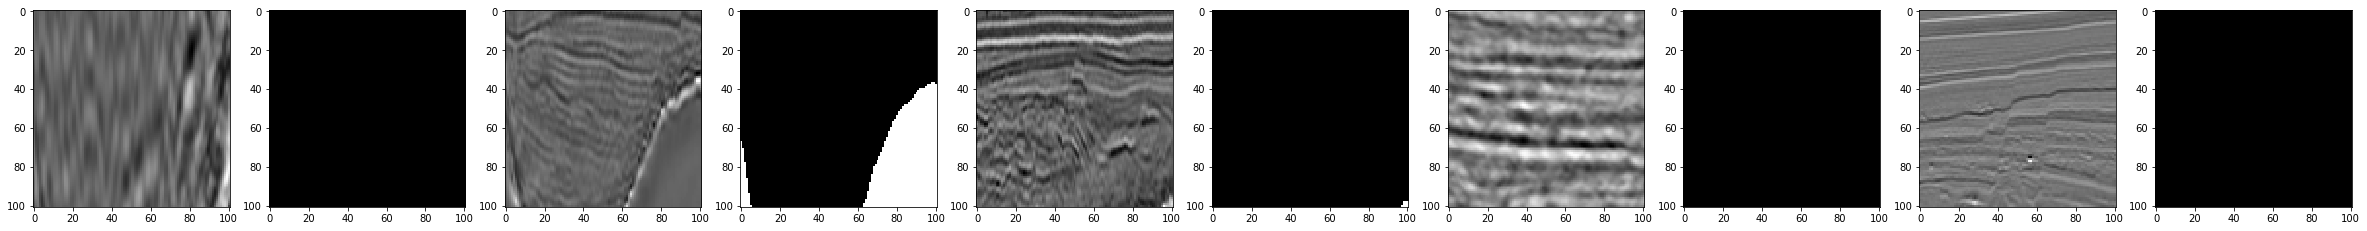

In [7]:
ids= ['1f1cc6b3a4','5b7c160d0d','6c40978ddf','7dfdf6eeb8','7e5a6e5013']
plt.figure(figsize=(50,25))
for j, img_name in enumerate(ids):
    q = j+1
    img = load_img(trainFolder + 'images/' + img_name + '.png')
    img_mask = load_img(trainFolder + 'masks/' + img_name + '.png')
    
    plt.subplot(1,2*(1+len(ids)),q*2-1)
    plt.imshow(img)
    plt.subplot(1,2*(1+len(ids)),q*2)
    plt.imshow(img_mask)
plt.show()

In [8]:
%load_ext autoreload
%autoreload 2

import ImageReader

In [9]:
train_ids = next(os.walk(trainFolder +"images"))[2]
test_ids = next(os.walk(testFolder +"images"))[2]

In [10]:
X_train, Y_train, depthVals = ImageReader.ReadSegmentationImages(trainFolder, depthFile)

  1%|          | 34/4000 [00:00<00:11, 334.00it/s]

Getting images and masks ... 


100%|██████████| 4000/4000 [00:11<00:00, 340.17it/s]


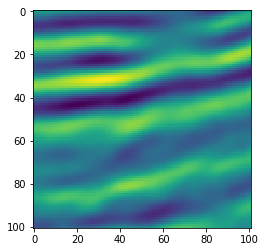

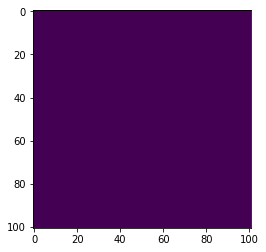

In [11]:
# Check if training data looks all right
ix = np.random.randint(0, len(train_ids))
#plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.imshow(X_train[ix,:,:,0])
plt.show()
plt.imshow(Y_train[ix,:,:,0])
plt.show()

# Keras datagen

In [12]:
valRatio = 0.02
nVal = int(len(X_train)*valRatio)
X_val = X_train[0:nVal]
Y_val = Y_train[0:nVal]
d_val = depthVals[0:nVal]

X_train0 = X_train[nVal:]
Y_train0 = Y_train[nVal:]
d_train0 = depthVals[nVal:]
X_train0.shape
print('{}, {}'.format(X_train0.shape, X_val.shape))

(3920, 101, 101, 1), (80, 101, 101, 1)


In [13]:
from keras.preprocessing.image import ImageDataGenerator

# we create two instances with the same arguments
data_gen_args = dict(#featurewise_center=True,
                     #featurewise_std_normalization=True,
                     rotation_range=1.0, #1.0,
                     #shear_range = 0.001, #0
                     zoom_range = 0.13, #0
                     width_shift_range=0.025, # 0.03,
                     height_shift_range=0.03, #0.3,
                     horizontal_flip=True,
                     fill_mode = "reflect"
                     #vertical_flip=True #see if helps
                    )

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)
depth_datagen = ImageDataGenerator()
seed=7
# Provide the same seed and keyword arguments to the fit and flow methods
image_datagen.fit(X_train0, augment=True, seed=seed)
mask_datagen.fit(Y_train0, augment=True, seed=seed)
depth_datagen.fit(d_train0, augment=False, seed=seed)

image_generator = image_datagen.flow(
    X_train0,
    seed=seed,
    batch_size = 32)#32*nGPUs)

mask_generator = mask_datagen.flow(
    Y_train0,
    seed=seed,
    batch_size = 32)#32*nGPUs)

depth_generator = depth_datagen.flow(
    d_train0,
    seed=seed,
    batch_size = 32)#32*nGPUs)

bSize = 32
def multi_input_gen(X1, X2, X3):
    genX1 = image_datagen.flow(X1, seed=7, batch_size=bSize)
    genX2 = depth_datagen.flow(X2, seed=7, batch_size=bSize)
    genX3 = mask_datagen.flow( X3, seed=7, batch_size=bSize)
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            X3i = genX3.next()
            yield [X1i, X2i], X3i

train_generator = multi_input_gen(X_train0, d_train0, Y_train0) #zip( [image_generator, depth_generator] , [mask_generator] )

730.0


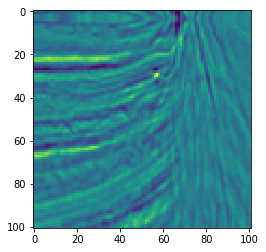

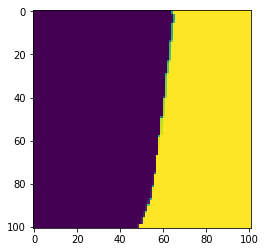

In [14]:
ans = next(train_generator)
print(ans[0][1][17,0,0,0])
plt.imshow( ans[0][0][17,:,:,0] )
plt.show()
plt.imshow( ans[1][17,:,:,0] )
plt.show()
#    
#    plt.imshow(xx[1][0][0,:,:,0])
#    plt.show()
#    break

# UNet model

In [15]:
import ModelUNet

from keras.utils import plot_model
from keras.models import Model, load_model
from keras.layers import Input, ZeroPadding2D, Cropping2D
from keras.layers.core import Lambda

In [16]:
im_height = 101
im_width = 101
im_chan = 1


inputImg = Input((im_height, im_width, im_chan))
inputDepth = Input( (1,1,1) )

s = Lambda(lambda x: x / 255) (inputImg)
dd = Lambda(lambda x: x * 0.001) (inputDepth)

#s = ReflectionPadding2D( padding = ((13, 14), (13, 14)) ) (s)
s = ZeroPadding2D( padding = ((13, 14), (13, 14)) ) (s)

unet = ModelUNet.BuildUNet(convFunction = ModelUNet.ApplyConv, net_depth=4)
s = unet([s,dd])

outputs = Cropping2D(cropping=((13, 14), (13, 14)) ) (s)

model = Model(inputs=[inputImg, inputDepth], outputs=[outputs])
model.compile(optimizer='adam', loss=ModelUNet.dice_loss, metrics=[ModelUNet.mean_iou])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 101, 101, 1)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 101, 101, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1, 1, 1)      0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 128, 128, 1)  0           lambda_1[0][0]                   
__________________________________________________________________________________________________
lambda_2 (

In [17]:
unet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  80          input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 8)  32          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 8)  0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

# Training

In [18]:
import math
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
def step_decay(epoch):
    initial_lrate = 0.0032
    drop = 0.955
    epochs_drop = 5.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    
    if (lrate < 4e-5):
        lrate = 4e-5
      
    print('Changing learning rate to {}'.format(lrate))
    return lrate
lrate = LearningRateScheduler(step_decay)

In [19]:
earlystopper = EarlyStopping(patience=35, verbose=1)
checkpointer = ModelCheckpoint('model-tgs-salt-1.h5', verbose=1, save_best_only=True)
#results = model.fit([X_train0, d_train0], Y_train0, validation_split=0.08, batch_size=16, epochs=100, 
#                    callbacks=[earlystopper, checkpointer, lrate])

results = model.fit_generator(train_generator, epochs=200, steps_per_epoch=len(X_train0) / 32, 
                              validation_data=( [X_val, d_val], Y_val),
                              callbacks=[earlystopper, checkpointer, lrate])


Epoch 1/200
Changing learning rate to 0.0032
123/122 [==============================] - 31s 250ms/step - loss: 0.0767 - mean_iou: 0.5196 - val_loss: 0.0765 - val_mean_iou: 0.5934

Epoch 00001: val_loss improved from inf to 0.07650, saving model to model-tgs-salt-1.h5
Epoch 2/200
Changing learning rate to 0.0032
123/122 [==============================] - 23s 191ms/step - loss: 0.0512 - mean_iou: 0.6228 - val_loss: 0.0450 - val_mean_iou: 0.6425

Epoch 00002: val_loss improved from 0.07650 to 0.04503, saving model to model-tgs-salt-1.h5
Epoch 3/200
Changing learning rate to 0.0032
123/122 [==============================] - 23s 191ms/step - loss: 0.0504 - mean_iou: 0.6524 - val_loss: 0.1185 - val_mean_iou: 0.6600

Epoch 00003: val_loss did not improve from 0.04503
Epoch 4/200
Changing learning rate to 0.0032
123/122 [==============================] - 23s 191ms/step - loss: 0.0448 - mean_iou: 0.6672 - val_loss: 0.0631 - val_mean_iou: 0.6748

Epoch 00004: val_loss did not improve from 0.0450

123/122 [==============================] - 23s 188ms/step - loss: 0.0239 - mean_iou: 0.7933 - val_loss: 0.0217 - val_mean_iou: 0.7941

Epoch 00038: val_loss did not improve from 0.01742
Epoch 39/200
Changing learning rate to 0.0023183210545186074
123/122 [==============================] - 23s 187ms/step - loss: 0.0241 - mean_iou: 0.7947 - val_loss: 0.0255 - val_mean_iou: 0.7954

Epoch 00039: val_loss did not improve from 0.01742
Epoch 40/200
Changing learning rate to 0.0022139966070652698
123/122 [==============================] - 23s 188ms/step - loss: 0.0235 - mean_iou: 0.7960 - val_loss: 0.0255 - val_mean_iou: 0.7967

Epoch 00040: val_loss did not improve from 0.01742
Epoch 41/200
Changing learning rate to 0.0022139966070652698
123/122 [==============================] - 23s 190ms/step - loss: 0.0231 - mean_iou: 0.7974 - val_loss: 0.0237 - val_mean_iou: 0.7980

Epoch 00041: val_loss did not improve from 0.01742
Epoch 42/200
Changing learning rate to 0.0022139966070652698
123/122 [===

123/122 [==============================] - 23s 190ms/step - loss: 0.0183 - mean_iou: 0.8273 - val_loss: 0.0207 - val_mean_iou: 0.8276

Epoch 00071: val_loss did not improve from 0.01713
Epoch 72/200
Changing learning rate to 0.0016795664099450833
123/122 [==============================] - 23s 190ms/step - loss: 0.0177 - mean_iou: 0.8280 - val_loss: 0.0208 - val_mean_iou: 0.8284

Epoch 00072: val_loss did not improve from 0.01713
Epoch 73/200
Changing learning rate to 0.0016795664099450833
123/122 [==============================] - 23s 190ms/step - loss: 0.0168 - mean_iou: 0.8289 - val_loss: 0.0225 - val_mean_iou: 0.8293

Epoch 00073: val_loss did not improve from 0.01713
Epoch 74/200
Changing learning rate to 0.0016795664099450833
123/122 [==============================] - 23s 190ms/step - loss: 0.0185 - mean_iou: 0.8296 - val_loss: 0.0197 - val_mean_iou: 0.8300

Epoch 00074: val_loss did not improve from 0.01713
Epoch 75/200
Changing learning rate to 0.0016039859214975543
123/122 [===

In [46]:
# list all data in history
print(results.history.keys())

dict_keys(['val_loss', 'val_mean_iou', 'loss', 'mean_iou'])


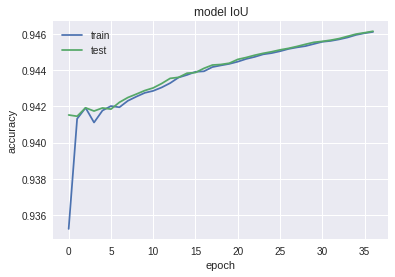

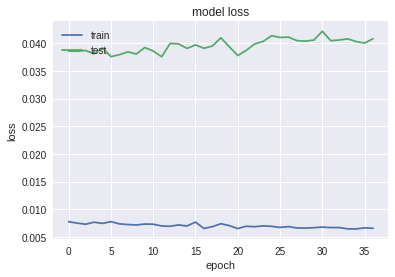

In [47]:
# summarize history for intersestion over union
plt.plot(results.history['mean_iou'])
plt.plot(results.history['val_mean_iou'])
plt.title('model IoU')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
model = load_model('model-tgs-salt-1.h5', custom_objects={'mean_iou': mean_iou, 'relu6':relu6,'BilinearUpsampling':BilinearUpsampling, 'dice_loss' : dice_loss}) #, 'ReflectionPadding2D' : ReflectionPadding2D})
#model.save('model-tgs-salt-1.h5')

In [0]:
#from google.colab import files
#files.download('model-tgs-salt-1.h5')
#files.upload()

In [42]:
preds_train = model.predict([X_train0, d_train0], verbose=1)
preds_val = model.predict([X_val, d_val], verbose=1)

80/80 [==============================] - 0s 2ms/step


In [43]:
threshList = []
IoUList = []
IoUValList = []
for kk in tqdm(range(21)):
    thresh = (1+kk)/21
    threshList.append(thresh)
    preds_train_t = (preds_train > thresh).astype(np.uint8)
    preds_val_t = (preds_val > thresh).astype(np.uint8)
    meanIoU = np.array([ModelUNet.IoU(preds_train_t[i], Y_train0[i]) for i in range(Y_train0.shape[0])])
    IoUList.append(np.mean(meanIoU) )
    meanIoUVal = np.array([ModelUNet.IoU(preds_val_t[i], Y_val[i]) for i in range(Y_val.shape[0])])
    IoUValList.append(np.mean(meanIoUVal) )

100%|██████████| 11/11 [01:09<00:00,  6.35s/it]


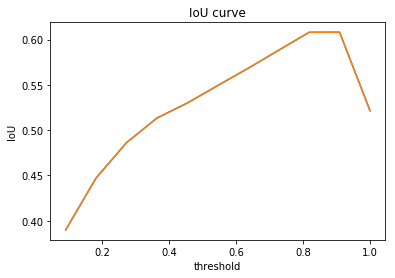

In [44]:
plt.title('IoU curve')
plt.ylabel('IoU')
plt.xlabel('threshold')

plt.plot(threshList, IoUList)
plt.plot(threshList, IoUValList)

In [45]:
thresh = threshList[np.argmax(IoUValList)]
print('Thresh: {}  ExpectedIoU: {}'.format(thresh, max(IoUValList)))

Thresh: 0.9090909090909091  ExpectedIoU: 0.608061224489796


In [47]:
thresh = 0.5

# Predictions

In [50]:
X_test, d_test = ImageReader.ReadSegmentationImages(testFolder, depthFile, readMasks = False)

  0%|          | 36/18000 [00:00<00:50, 357.64it/s]

Getting images and masks ... 


100%|██████████| 18000/18000 [00:47<00:00, 375.91it/s]


In [52]:
model_array = [
               #load_model('model-tgs-salt-Resnet.h5', custom_objects={'mean_iou': mean_iou, 'ReflectionPadding2D' : ReflectionPadding2D}),
               #load_model('model-tgs-salt-ReflecConv.h5', custom_objects={'mean_iou': mean_iou, 'ReflectionPadding2D' : ReflectionPadding2D}),
               #load_model('model-tgs-salt-Incep1.h5', custom_objects={'mean_iou': mean_iou, 'ReflectionPadding2D' : ReflectionPadding2D}),
              ]

# Predict on train, val and test

preds_train = model.predict([X_train0, d_train0], verbose=1)
preds_val = model.predict([X_val, d_val], verbose=1)
preds_test = model.predict([X_test, d_test], verbose=1)

for savedModel in model_array:
    preds_train += savedModel.predict([X_train0, d_train0], verbose=1)
    preds_val += savedModel.predict([X_val, d_val], verbose=1)
    preds_test += savedModel.predict([X_test, d_test], verbose=1)

preds_train /= 1+len(model_array)
preds_val /= 1+len(model_array)
preds_test /= 1+len(model_array)


# Threshold predictions
preds_train_t = (preds_train > thresh).astype(np.uint8)
preds_val_t = (preds_val > thresh).astype(np.uint8)
preds_test_t = (preds_test > thresh).astype(np.uint8)


18000/18000 [==============================] - 34s 2ms/step


In [53]:
preds_test_t.shape

(18000, 101, 101, 1)

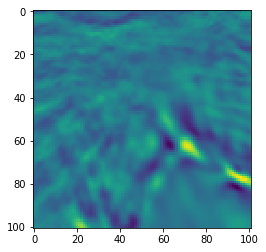

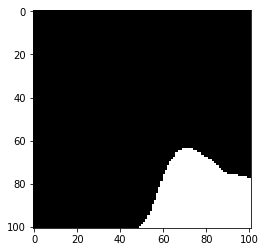

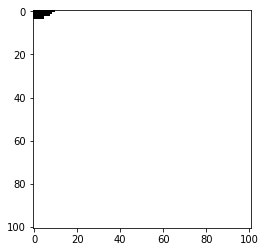

In [54]:
# Perform a sanity check on some random training samples
ix = np.random.randint(0, len(preds_train_t))
plt.imshow(X_train[ix,:,:,0])
plt.show()
#plt.imshow(Y_train[ix,:,:,0])
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()
tmp = np.squeeze(preds_train_t[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

In [55]:
lowPixCount = [imgId for imgId in range(len(preds_test_t)) if preds_test_t[imgId].sum() < 10 and preds_test_t[imgId].sum() > 0]
len(lowPixCount)

409

In [0]:
for imId in lowPixCount:
    preds_test_t[imId]=np.zeros( (101,101,1) )

# Prepare Submission

In [36]:
print(preds_test_t.shape)
preds_test = preds_test_t.reshape(preds_test_t.shape[0], preds_test_t.shape[1], preds_test_t.shape[2])
print(preds_test.shape)

(18000, 101, 101, 1)
(18000, 101, 101)


In [0]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

#pred_dict = {fn[:-4]:RLenc(np.round(preds_test[i])) for i,fn in tqdm(enumerate(test_ids))}
pred_dict = {fn[:-4]:RLenc(np.round(preds_test[i])) for i,fn in (enumerate(test_ids))}

In [0]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')

In [39]:
import zipfile
try:
    import zlib
    compression = zipfile.ZIP_DEFLATED
except:
    compression = zipfile.ZIP_STORED

modes = { zipfile.ZIP_DEFLATED: 'deflated',
          zipfile.ZIP_STORED:   'stored',
          }

print('creating archive')
zf = zipfile.ZipFile('submission.zip', mode='w')
try:
    print('adding with compression mode {}'.format(modes[compression]))
    zf.write('submission.csv', compress_type=compression)
finally:
    print('closing')
    zf.close()

print('submission.zip')

creating archive
adding with compression mode deflated
closing
submission.zip


In [40]:
!kaggle competitions submit -c tgs-salt-identification-challenge -f submission.zip -m "Deeplab xception + median filter on input"

Successfully submitted to TGS Salt Identification Challenge

In [0]:
from google.colab import files
files.download('submission.zip')